In [2]:
from collections import defaultdict, deque
import random
import numpy as np
import os
from typing import *
from tqdm import tqdm
import networkx as nx
from matplotlib import pyplot as plt

DEFAULT_DATA_FOLDER = "./networks"

In [3]:
def read(filepath):
    G = nx.Graph()
    with open(filepath, 'r') as file:
        line = file.readline()
        n = int(line.strip().split(" ")[1])
        for _ in range(n):
            parts = file.readline().strip().split("!")
            id = int(parts[0])
            name = parts[1]
            label = parts[2].strip()
            G.add_node(id, name=name, label=label)
        line = file.readline()
        m = int(line.strip().split(" ")[1])
        for _ in range(m):
            parts = file.readline().strip().split(" ")
            G.add_edge(int(parts[0]), int(parts[1]))
    return G


filepath = "works.net"
G = read(filepath)
n = G.number_of_nodes()
m = G.number_of_edges()
G.name = "works"
print(n)
print(m)

6478
31070


In [4]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def read_edgelist(filename: str, data_folder=DEFAULT_DATA_FOLDER, progress_bar=False) -> nx.Graph:
    """Reads a network in edgelist (.adj) format. Assumes directed links
    unless the term `undirected` is stated in the header."""
    filename = os.path.splitext(filename)[0]
    
    edges: List[Tuple[int, int]] = []

    with open(os.path.join(data_folder, f"{filename}.adj")) as f:
        comments = ""
        for line in f:
            if line[0] == '#': comments += line[1:]
            else: break

        if progress_bar and (match := re.search(r"([\d,]+) edges", comments)):
            # get the first edge
            i, j = (int(x) - 1 for x in line.split())
            edges.append((i, j))
            
            m = int(match.group(1).replace(',', ''))
            # get the rest
            for _ in tqdm(range(m - 1), desc=f"reading {filename}"):
                i, j = (int(x) - 1 for x in next(f).split())
                edges.append((i, j))
        else:
            for line in f:
                i, j = (int(x) - 1 for x in line.split())
                edges.append((i, j))

    return nx.Graph(edges, name=filename)

In [5]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def info(G: nx.Graph, distance_sample: int | None = None,
         clustering_sample: int | None = 10_000) -> None:
    """Prints basic information on the provided graph.
    - If distance_sample is given, distance statistics will be computed from
    a sample of nodes (of given size).
    - If clustering_sample is given, average clustering will be computed from
    a sample of nodes (of given size).
    """
    print("{:>12s} | '{:s}'".format(str(G).split()[0], G.name))

    n = G.number_of_nodes()
    m = G.number_of_edges()

    print("{:>12s} | {:,d} (iso={:,d})".format(
        'Nodes', n, nx.number_of_isolates(G)))
    print("{:>12s} | {:,d} (loop={:,d})".format(
        'Edges', m, nx.number_of_selfloops(G)))

    if G.is_directed():
        print("{:>12s} | {:.2f} max(in={:d}, out={:d})".format(
            'Degree', m / n, max(k for _, k in G.in_degree()),
            max(k for _, k in G.out_degree())))
    else:
        print("{:>12s} | {:.2f} (max={:,d})".format(
            'Degree', 2 * m / n, max((k for _, k in G.degree()))))

    C = list(nx.connected_components(nx.Graph(G) if G.is_directed else G))
    largest_comp = max(C, key=len)

    print("{:>12s} | {:.1f}% (n={:,d})".format(
        'LCC', 100 * len(largest_comp) / n, len(C)))

    if distance_sample is not None:
        G_lcc = G.subgraph(largest_comp)
        if n <= distance_sample:
            mean = nx.average_shortest_path_length(G_lcc)
            diam = nx.diameter(G_lcc)
        else:
            D = distances(G_lcc, n=distance_sample)
            mean = np.mean(D)
            diam = max(D)

        print("{:>12s} | {:.2f} (max={:,d})".format('Distance', mean, diam))

    if clustering_sample is not None:
        if isinstance(G, nx.MultiGraph):
            G = nx.Graph(G)

        clustering_on = G.nodes if n <= clustering_sample \
            else random.sample(list(G.nodes), k=clustering_sample)

        print("{:>12s} | {:.4f}".format(
            'Clustering', nx.average_clustering(G, clustering_on)))
    print()

In [6]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def plot_degree(G: nx.Graph, save_path: str | None = None) -> None:
    """Plots degree distribution(s) on a log-log plot.
    If save_path is given, the plot will be saved in given folder/file
    instead of being shown."""
    plt.clf()
    plt.title(G.name + " degree distribution")
    plt.ylabel('$p_k$')
    plt.xlabel('$k$')
    n = G.number_of_nodes()

    def aux(degree_view: Iterable, k_min: int, **kwargs):
        degree_count = Counter(k for _, k in degree_view)
        k_max = max(degree_count.keys())

        x = list(range(k_min, k_max + 1))
        y = [degree_count[i] / n for i in x]
        plt.loglog(x, y, 'o', **kwargs)

    if G.is_directed():
        aux(G.out_degree, k_min=0, label="outdegree", color="pink")
        aux(G.in_degree, k_min=0, label="indegree", color="purple", alpha=0.5)
        plt.legend()
    else:
        aux(G.degree, k_min=1, color="gray")

    if save_path is None:
        plt.show()
    else:
        if len(os.path.splitext(save_path)[1]) == 0: # no extension
            plt.savefig(os.path.join(save_path, f"{G.name}_degree_distro.pdf"))
        else:
            plt.savefig(save_path)

       Graph | 'works'
       Nodes | 6,478 (iso=81)
       Edges | 31,070 (loop=0)
      Degree | 9.59 (max=6,082)
         LCC | 98.7% (n=82)
  Clustering | 0.0000



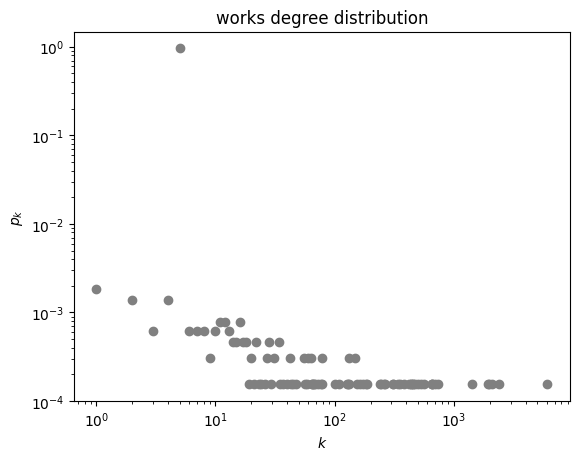

In [7]:
info(G)
plot_degree(G)

In [8]:

for node in G.nodes():
    print("Node", node, "has value:", G.nodes[node])

Node 1 has value: {'name': 'John Adams', 'label': 'Composer'}
Node 2 has value: {'name': 'Thomas AdĂ¨s', 'label': 'Composer'}
Node 3 has value: {'name': 'Isaac AlbĂ©niz', 'label': 'Composer'}
Node 4 has value: {'name': 'Tomaso Albinoni', 'label': 'Composer'}
Node 5 has value: {'name': 'George Antheil', 'label': 'Composer'}
Node 6 has value: {'name': 'Malcolm Arnold', 'label': 'Composer'}
Node 7 has value: {'name': 'Milton Babbitt', 'label': 'Composer'}
Node 8 has value: {'name': 'Johann Sebastian Bach', 'label': 'Composer'}
Node 9 has value: {'name': 'Carl Philipp Emanuel Bach', 'label': 'Composer'}
Node 10 has value: {'name': 'Johann Christian Bach', 'label': 'Composer'}
Node 11 has value: {'name': 'Mily Balakirev', 'label': 'Composer'}
Node 12 has value: {'name': 'Samuel Barber', 'label': 'Composer'}
Node 13 has value: {'name': 'BĂ©la BartĂłk', 'label': 'Composer'}
Node 14 has value: {'name': 'Arnold Bax', 'label': 'Composer'}
Node 15 has value: {'name': 'Ludwig van Beethoven', 'labe

In [9]:
# vir: https://github.com/lovre/www/blob/master/ina/labs/utils.py

def top_nodes(G: nx.Graph, C: Dict[Any, float], centrality: str, n=15) -> List[Any]:
    """prints and returns top n nodes by given measure of centrality"""

    # OPT take callable instead of dict, only compute centrality on non-mode nodes
    # OPT np.argpartition instead of sort
    print("{:>12s} | '{:s}'".format('Centrality', centrality))
    nodes = []
    for i, c in sorted(C.items(), key=lambda item: (item[1], G.degree[item[0]]), reverse=True):
        # if G.nodes[i]['label'] == 'Key':
        nodes.append(G.nodes[i])
        print("{:>12.6f} | '{:s}' ({:,d}) '{:s}'".format(
            c, G.nodes[i]['label'], G.degree[i], G.nodes[i]['name'][:30]))
        n -= 1
        if n == 0:
            break
    print()
    return nodes


def nodes_names(nodes) -> List[str]:
    """Parses labels of nodes in collaboration_imdb.net into
    a nicer format. Try pasting the ouput of this function into
    chatGPT if you have trouble classifying the actors."""
    names = []
    for n in nodes:
        try:
            last, fst = n["label"].split(", ")
            if fst[-1] == ')':
                fst = fst[:fst.index('(') - 1]

            names.append(f"{fst} {last}")
        except ValueError: # failed unpacking
            names.append(n["label"])

    return names


In [10]:
nx.pagerank(G)

{1: 2.3404039537224126e-05,
 2: 2.3404039537224126e-05,
 3: 0.0002042019879225968,
 4: 0.0009777307138903828,
 5: 2.3404039537224126e-05,
 6: 2.3404039537224126e-05,
 7: 2.3404039537224126e-05,
 8: 0.0035092327657686483,
 9: 0.004576107851568579,
 10: 0.001971616180781014,
 11: 0.00033776682648099685,
 12: 8.673467289402671e-05,
 13: 0.00026481924112554733,
 14: 0.0001896519954614455,
 15: 0.0027806447511152686,
 16: 0.00011535730274603947,
 17: 0.0002336595376195494,
 18: 2.3404039537224126e-05,
 19: 2.3404039537224126e-05,
 20: 2.3404039537224126e-05,
 21: 0.00034963756078857007,
 22: 0.0005685746811182338,
 23: 2.3404039537224126e-05,
 24: 5.686494662379761e-05,
 25: 5.693974487081155e-05,
 26: 0.0018840764625593647,
 27: 0.00011554507221925409,
 28: 2.3404039537224126e-05,
 29: 4.2090074451133855e-05,
 30: 0.0006905003540430874,
 31: 0.00020422859585743299,
 32: 0.00029415608265837955,
 33: 0.0004823093340628838,
 34: 0.0002621363423463322,
 35: 0.0009048096315345906,
 36: 0.000660

In [11]:
nodes_names(top_nodes(G, nx.pagerank(G), 'pagerank'))

  Centrality | 'pagerank'
    0.089673 | 'Popularity' (6,082) 'Nonpopular'
    0.034928 | 'Period' (2,381) 'Baroque'
    0.030953 | 'Genre' (2,098) 'Chamber'
    0.029142 | 'Genre' (1,976) 'Orchestral'
    0.028846 | 'Genre' (1,955) 'Keyboard'
    0.020706 | 'Period' (1,412) 'Classical'
    0.010878 | 'Period' (730) 'Romantic'
    0.010243 | 'Period' (694) 'Early Romantic'
    0.009810 | 'Period' (656) 'Late Romantic'
    0.009698 | 'Key' (659) 'D major'
    0.009645 | 'Key' (654) 'C major'
    0.008175 | 'Composer' (557) 'Domenico Scarlatti'
    0.007821 | 'Key' (531) 'G major'
    0.007407 | 'Key' (501) 'B flat major'
    0.006955 | 'Key' (472) 'F major'



['Popularity',
 'Period',
 'Genre',
 'Genre',
 'Genre',
 'Period',
 'Period',
 'Period',
 'Period',
 'Key',
 'Key',
 'Composer',
 'Key',
 'Key',
 'Key']

In [5]:
import sys
print(sys.path)


['d:\\2.2.2\\ARPI\\ina-project-song-signatures', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\franc\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages', 'C:\\Users\\franc\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32', 'C:\\Users\\franc\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\franc\\AppData\\Local\

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import json
import os
import dotenv as dt

dt.load_dotenv(dotenv_path='.env')

def authenticate(interval):
    client_id = os.getenv(f"CLIENT_ID_{interval}")
    client_secret = os.getenv(f"CLIENT_SECRET_{interval}")
    
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    return sp


In [13]:
def get_uuid(track_name, sp):
    search_results = sp.search(q=track_name, type='track', limit=1)

    # Extract UUID of the first track (assuming it's the one you're looking for)
    if search_results['tracks']['items']:
        track_uuid = search_results['tracks']['items'][0]['id']
        return track_uuid
    else:
        return None

In [ ]:
sp = authenticate(2)
uuid = get_uuid('Primera barcarolla', sp)
td = sp.track(uuid)

In [18]:
def get_popularity(track_uuid, sp):
    track_details = sp.track(track_uuid)
    popularity = track_details['popularity']
    return popularity

In [19]:
def save_dict(works):
    with open('works.json', 'w') as f:
        json.dump(works, f)
        print("Saved works to works.json")

In [39]:
# obratno preberemo podatke
with open('works.json', 'r') as f:
    works = json.load(f)

In [21]:
# works = {}
indy = 0
last_auth_time = time.time()
start_time = time.time()

sp = authenticate(0)
interval = 0

for node in G.nodes():
    if G.nodes[node]['label'] == 'Work':
        if str(node) in works.keys():
            continue
        current_time = time.time()  
        if current_time - last_auth_time > 300: 
            sp = authenticate(interval)
            interval = (interval + 1) % 5
            last_auth_time = current_time
        if indy % 500 == 0:
            save_dict(works)
        works[node] = {'name': G.nodes[node]['name']}  
        works[node]['uuid'] = get_uuid(works[node]['name'], sp)
        if works[node]['uuid'] is not None:
            works[node]['popularity'] = get_popularity(works[node]['uuid'], sp) + 1
            indy += 1
            if indy % 50 == 0: print(indy, time.time() - start_time)
        else:
            works[node]['popularity'] = 1


Saved works to works.json
50 21.19952130317688
100 38.6025071144104
150 56.97168493270874
200 70.76010608673096
250 84.75259900093079
300 99.33606481552124
350 114.48605442047119
400 130.1521179676056
450 145.42572331428528
500 160.1616153717041
Saved works to works.json
550 173.62103128433228
600 188.91130328178406
650 203.50386595726013
700 218.68550300598145
750 233.07100701332092
800 248.87316370010376
850 263.2751638889313
900 279.54073905944824
950 293.03735852241516
1000 308.8971788883209
Saved works to works.json
1050 324.0879473686218
1100 336.85490679740906
1150 350.89181637763977
1200 366.02843618392944
1250 381.1307511329651
1300 393.6986927986145
1350 410.2807536125183
1400 425.7388446331024
1450 439.94847798347473
1500 453.452068567276
Saved works to works.json
1550 468.09415340423584
1600 482.69926142692566
1650 497.74722814559937
1700 511.8878107070923


In [38]:
# zato, da ne rabimo vsakič znova klicati API-ja sem shranil podatke v datoteko
save_dict(works)

Saved works to works.json


In [ ]:
# obratno preberemo podatke
with open('works.json', 'r') as f:
    works = json.load(f)

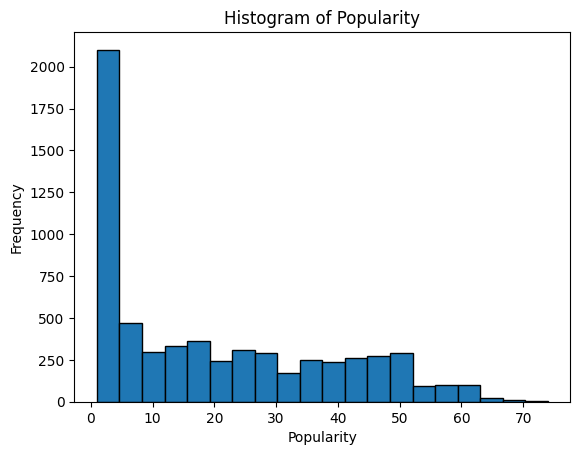

In [27]:
import matplotlib.pyplot as plt

popularity_values = [works[node]['popularity'] for node in works if 'popularity' in works[node]]

plt.hist(popularity_values, bins=20, edgecolor='black')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Histogram of Popularity')
plt.show()

In [26]:
print(sum([1 if works[node]['popularity'] == 1 else 0 for node in works]))
print(len(works))

1269
6214
